# Logbook 4
## N-body choreographies

08/03/23

Orbits of multiple bodies with the same mass.

In [1]:
#Import statements
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

# Lagrange points for a regular triangle

Objects of the same mass, aranged in a triangle

Distance of 1 from the origin, centre of mass at origin.

r1 = [1, 0, 0] $\newline$
r2 = [-1/2, $\sqrt{3}/2$, 0] $\newline$
r3 = [-1/2, -$\sqrt{3}/2, 0$]

For the velocities, we need to spin all three masses with the same angular velocity.

$\omega = \frac{v}{r}$

The radius of the orbits is 1 and we will spin the planets with $\omega \sim 0.76$ meaning the magnitude of velocity will be 0.76, in the direction perpendicular to the line between the object and the origin.

I obtained this value of $\omega$ using the formula from [http://diposit.ub.edu/dspace/bitstream/2445/181716/2/tfg_victor_sanchez_linan.pdf, pg26, eq2.13]


In [2]:
def three_body_update_3D(t, init_list, G, m1, m2, m3):
    """updated positions and velocities for 3 bodies 
    
    Inputs:
    t: time variable
    init_list: list of variables - 
                                [x1, y1, z1, x2, y2, z2, x3, y3, z3, 
                                Vx1, Vy1, Vz1, Vx2, Vy2, Vz2, Vx3, Vy3, Vz3]
    G: Value of gravity: const
    m1: mass of object 1
    m2: mass of object 2
    m3: mass of object 3
    Returns:
    next_val: Array containing updated values based on differential equations
    """


    r1 = np.array(init_list[:3])
    r2 = np.array(init_list[3:6])
    r3 = np.array(init_list[6:9])
    
    v1 = np.array(init_list[9:12])
    v2 = np.array(init_list[12:15])
    v3 = np.array(init_list[15:18])
    
    r12=np.linalg.norm(r2-r1)
    r13=np.linalg.norm(r3-r1)
    r23=np.linalg.norm(r3-r2)

    
    dv1 = G * m2 * (r2 - r1)/(r12**3) + G * m3 * (r3 - r1)/(r13**3)
    dv2 = G * m1 * (r1 - r2)/(r12**3) + G * m3 * (r3 - r2)/(r23**3)
    dv3 = G * m1 * (r1 - r3)/(r13**3) + G * m2 * (r2 - r3)/(r23**3)
    
    dr1 = v1
    dr2 = v2
    dr3 = v3
    
    next_val = np.concatenate((dr1, dr2, dr3, dv1, dv2, dv3))
    
    return next_val

In [3]:
#Setting up initial conditions
r1_0_L = np.array((1, 0, 0))
r2_0_L = np.array((-1/2, np.sqrt(3)/2, 0))
r3_0_L = np.array((-1/2, -np.sqrt(3)/2, 0))

m1 = 1
m2 = 1
m3 = 1
G = 1

N=.76 #Value of velocity scaling
v1_0_L = N*np.array((0, 1, 0))
v2_0_L = N*np.array((-np.sqrt(3)/2, -1/2, 0))
v3_0_L = N*np.array((np.sqrt(3)/2, -1/2, 0))

t_eval = np.linspace(0, 20, 10000)

init_list = np.concatenate((r1_0_L, r2_0_L, r3_0_L, v1_0_L, v2_0_L, v3_0_L))

In [4]:
lagSol = integrate.solve_ivp(three_body_update_3D, [0, 20], init_list, t_eval=t_eval, method='RK45', rtol=1e-6, args=(G, m1, m2, m3))

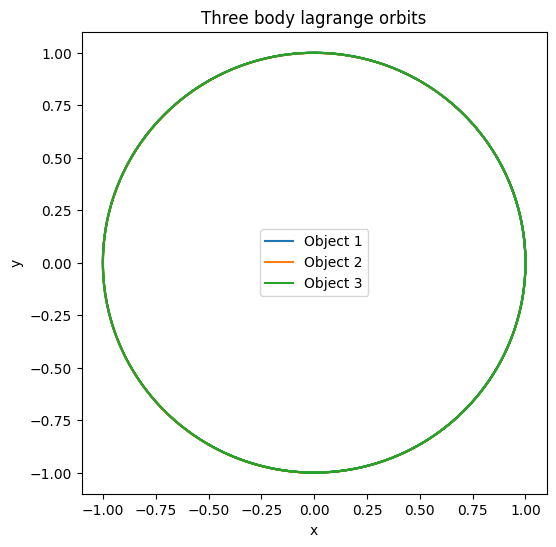

In [5]:
M = 10000
plt.figure(figsize=(6, 6))
plt.plot(lagSol.y[0, :M], lagSol.y[1, :M], label = "Object 1")
plt.plot(lagSol.y[3, :M], lagSol.y[4, :M], label="Object 2")
plt.plot(lagSol.y[6, :M], lagSol.y[7, :M], label = "Object 3")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Three body lagrange orbits")

plt.legend()

## Extending the triangle to more bodies

10/03/23

Extending the simulation of lagrange points to more bodies requires spinning a different sided n-gon and also simulating more bodies within the differential equation function. The N_body_update function defined below gives the differential equation calculations for any number of objects, however my update alogrithm is pretty slow so too many bodies makes the code take a long time to execute. Throughout this code I could have used numpy arrays and operations to carry out some tasks faster, however given after 8 bodies the orbits stopped being stable for any length of time anyway, the easier implementation via for loops and if statements I deemed okay.

To find the new angular velocities, I used the formula given in [http://diposit.ub.edu/dspace/bitstream/2445/181716/2/tfg_victor_sanchez_linan.pdf, pg26, eq2.13] which gives:

$$
\lambda = \frac{m}{lr^2}(1+\frac{l}{n}(\sum_{j=3}^{n-1} \frac{1}{r_{1j}} \sum_{i=2}^{n-2} \sum_{j=i+2}^{n} \frac{1}{r_{ij}})
$$
where
$$
\omega = \pm \sqrt{\lambda}
$$
$l$ is the length of one side of the n-gon
$\newline$
n is the number of sides of the n-gon

In [6]:
def N_body_update_2D(t, init_list):
    """Updates positions and velocities for N bodies, assumes masses of all bodies and G = 1 
    and position and velocity vectors to be 2D.
    
    Inputs:
    t: time variable
    init_list: list of initial and newly calcualated positions and velocities
    
    Returns:
    next_val: Array containing updated values based on differential equations
    """
    
    
    v_index = int(len(init_list)/2)
    next_v = []
    next_r = []
    
    for i in range(0, v_index, 2):
        r_i = init_list[i:i+2]
        v_i = init_list[v_index + i: v_index + i + 2]
        
        r_other = init_list[:v_index]
        r_other = np.concatenate((r_other[:i], r_other[i+2:]))
        
        v_new = np.array((0., 0.))
        for j in range(0, len(r_other), 2):
            v_new += (r_other[j:j+2] - r_i)/(np.linalg.norm(r_other[j:j+2] - r_i)**3)
        
        next_v.append(v_new)
        next_r.append(v_i)
    next_val = np.concatenate((next_r, next_v), axis=None)
    return next_val

In [7]:
def calc_ang_speed(pos, N):
    """ A function to calculate the angular speed needed to create a stable circular orbit 
    for lagrange points in a regular n-gon
    Inputs:
    pos: 2D list of position vectors
    N: number of bodies in the system
    Returns:
    omega: the angular speed for the given system
    """
    L = np.linalg.norm(pos[0] - pos[1])
    
    if N == 3:
        omega = np.sqrt(1/L)
        return omega
    elif N >= 4:
        #First sum in the formula
        sum1 = 0 
        for j in range(3, N):
            sum1 += 1/np.linalg.norm(pos[0] - pos[j-1])
        #Second sum in the formala    
        sum2 = 0
        for i in range(2, N-1):
            for j in range(i+2, N+1):
                sum2 += 1/(np.linalg.norm(pos[i-1] - pos[j-1])) 
                
        omega = np.sqrt(1/L * (1 + L/N * (sum1 + sum2)))
        return omega
        
    
    

In [8]:
#Get initial conditions for N bodies and set them
Nbody = 5 #This can be changed to simulate a different number of bodies
r = 1
theta = 2*np.pi
dtheta = theta/Nbody
r_list = np.zeros((Nbody, 2))
v_list = np.zeros((Nbody, 2))



for i in range(Nbody):
    x = r*np.cos(dtheta * i)
    y = r*np.sin(dtheta * i)
    r_list[i] = np.array([x, y])

    
omega = calc_ang_speed(r_list, Nbody) #Calculating the angular speed for a stable orbit

for j in range(0, Nbody):
    x = omega*r_list[j, 0]
    y = omega*r_list[j, 1]
    v_list[j] = np.array([-y, x])
    
t_eval = np.linspace(0, 20, 10000)
init_list_2 = np.concatenate((r_list, v_list), axis=None)

In [9]:
lagSol2 = integrate.solve_ivp(N_body_update_2D, [0, 20], init_list_2, t_eval=t_eval, method='RK45', rtol=1e-6)
print(lagSol2.success)

True


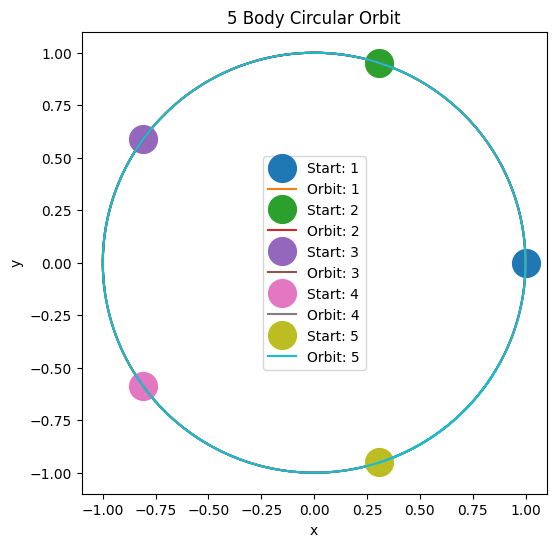

In [10]:
plt.figure(figsize=(6, 6))

M = 3000 #Number of terms to show

for i in range(0, int(len(init_list_2)/2),2):
    plt.plot(lagSol2.y[i, 0], lagSol2.y[i+1, 0], 'o', ms=20, label = f"Start: {int(i/2+1)}")
    plt.plot(lagSol2.y[i, :M], lagSol2.y[i+1, :M], label = f"Orbit: {int(i/2+1)}")

plt.xlabel("x")
plt.ylabel("y")
plt.title(f"{Nbody} Body Circular Orbit")

plt.legend()

With the old RK23 method the orbit of 7 bodies is stable only up to the first 8000 points in the array. Then for higher number of bodies it stays in the stable orbit pattern for less and less terms.

However for the RK45 method more bodies can be simulated before the stability becomes too short. 8 bodies has a fairly stable orbit for a long period of time, however by 9 bodies is reached it does not stay in the circular orbit pattern for very long at all.

## The Gerver orbit

10/03/23

Now I will be looking at the Gerver orbit, which, like with the lagrange points, is a choreography where all bodies follow the same orbit with a differing phase, however it does this in a figure-of-8-like pattern, rather than in a circle.

First I will look at the 4 body braid following the Gerver orbit pattern.

[https://ww2.ii.uj.edu.pl/~zgliczyn/papers/nbody/schoreo.pdf] - Table 5

In [11]:
#Setting up initial conditions
a = 0.157029944461
x1 = 1.382857
x0_dot = 1.87193510824
y1_dot = 0.584872579881

m1 = 1
m2 = 1
m3 = 1
m4 = 1

t_eval = np.linspace(0, 20, 10000)

init_params_gerver = np.array([0, a, x1, 0, 0, -a,  -x1, 0,
                                x0_dot, 0, 0, y1_dot, -x0_dot, 0, 0, -y1_dot])

In [12]:
def init_plot(init_params, title, limx, limy):
    """Plots the initial positions and first step direction for an array of 
       init_params of form [x1, x2,..., xn, v1, v2,...,vn]
       
       Inputs:
       init_params: Initial parameters to be plotted
       title: title of the graph
       limx, limy: Limits of plot in x and y direction as 2 element array eg [-2, 2]
    """
    # Plotting initial positions
    
    color = ['b', 'b', 'g', 'g', 'r', 'r', 'c', 'c', 'y', 'y', 'm', 'm'] #List of some matplotlib colors

    plt.figure(figsize=(6, 6))
    dt = 0.3 #Scaling of velocity arrow
    
    half_index = int(len(init_params)/2)

    for i in range(0, half_index, 2):
        plt.plot(init_params[i], init_params[i+1], 'o', ms=10, 
                 label = f"Start: {int(i/2+1)}", color=color[i])
        
        plt.arrow(init_params[i], init_params[i+1], 
                  dt*init_params[i+half_index], dt*init_params[i+half_index+1],
                 head_width = .1, facecolor = color[i], edgecolor = 'k')



    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"{title}")
    
    plt.xlim(limx)
    plt.ylim(limy)


    plt.legend()

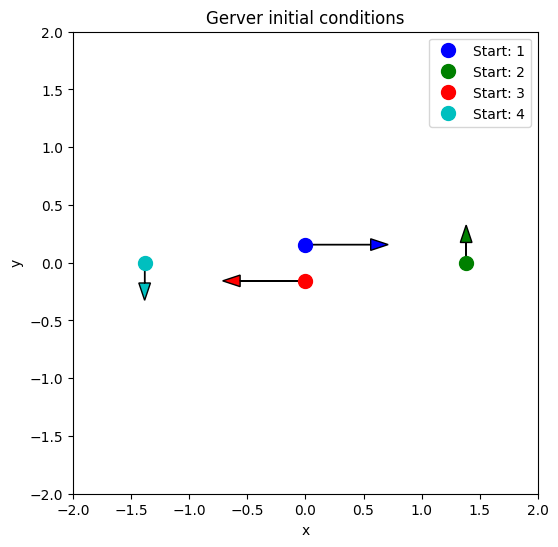

In [13]:
# Plotting initial positions
init_plot(init_params_gerver, "Gerver initial conditions", [-2, 2], [-2, 2])

I made an extra plot of the initial conditions to figure out which variables were which within $\bar{x}$ from the paper to get the positions that matched the initial positions from the paper.

In [14]:
gerver_sol = integrate.solve_ivp(N_body_update_2D, [0, 20], init_params_gerver, 
                                 t_eval=t_eval, method='RK45', rtol=1e-6)

In [15]:
print(gerver_sol.success)

True


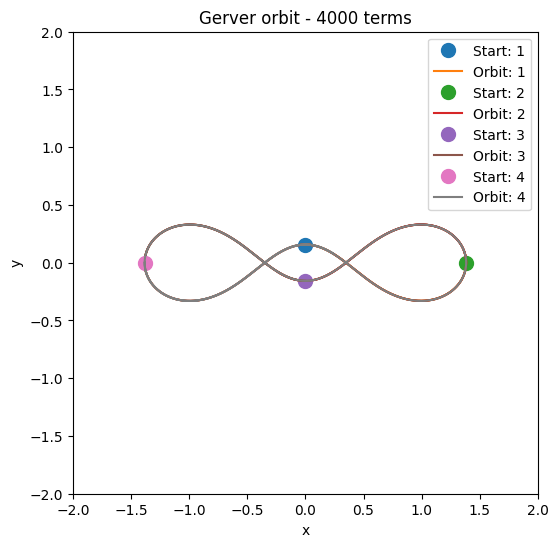

In [16]:
M = 4000
plt.figure(figsize=(6, 6))

for i in range(0, int(len(init_params_gerver)/2),2):
    plt.plot(gerver_sol.y[i, 0], gerver_sol.y[i+1, 0], 'o', ms=10, label = f"Start: {int(i/2+1)}")
    plt.plot(gerver_sol.y[i, :M], gerver_sol.y[i+1, :M], label = f"Orbit: {int(i/2+1)}")


plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Gerver orbit - {M} terms")

plt.xlim(-2, 2)
plt.ylim(-2, 2)

plt.legend()

From this graph, we can see that these initial conditions do take the expected pattern described in the paper, however inaccuracies in machine precision and the RK23 method quickly cause this to divert from the expected pattern after only around 400 terms, so this choreography is very sensitive to initial conditions.

## The 6 body braid 

11/03/23

We can extend the idea of the 4 body Gerver braid to theoretically a linear chain of any length, however the more bodies added the longer the calculations take, so in this example we will be looking at the 6 body linear chain orbit.

The initial conditions for this orbit have been obtained from:

[https://ww2.ii.uj.edu.pl/~zgliczyn/papers/nbody/schoreo.pdf] - table 7

In [17]:
x0_dot = -0.635277524319 
y1 = 0.140342838651 
x1 = 0.797833002006 
y1_dot = 0.100637737317 
x1_dot = -2.03152227864 

a = 1.887041548253914

#Old initial conditions - used initial conditions plot to check this was not right
"""
init_params_linear_chain = np.array([0, a, x1, y1, x1, -y1, 0, -a, -x1, -y1, -x1, y1,
                                    x0_dot, 0, x1_dot, y1_dot, -x1_dot, y1_dot, 
                                     -x0_dot, 0, -x1_dot, -y1_dot, x1_dot, y1_dot])
"""
#Working initial conditions
init_params_linear_chain = np.array([a, 0, x1, y1, -x1, y1, -a, 0, -x1, -y1, x1, -y1,
0, x0_dot, x1_dot, y1_dot, x1_dot, -y1_dot, 0, -x0_dot, -x1_dot, -y1_dot, -x1_dot, y1_dot])


t_eval = np.linspace(0, 20, 1000)

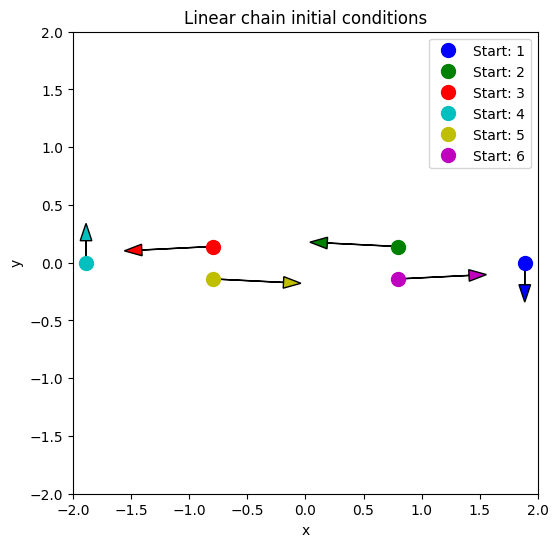

In [18]:
# Plotting initial positions

init_plot(init_params_linear_chain, "Linear chain initial conditions", [-2, 2], [-2, 2])

In [19]:
sixbody_linear_sol = integrate.solve_ivp(N_body_update_2D, [0, 20], init_params_linear_chain, 
                                 t_eval=t_eval, method='RK45', rtol=1e-6)
print(sixbody_linear_sol.success)

True


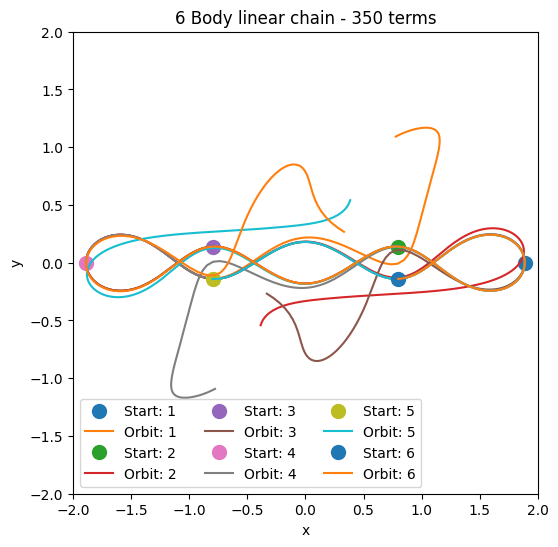

In [20]:
M = 350
plt.figure(figsize=(6, 6))

for i in range(0, int(len(init_params_linear_chain)/2),2):
    plt.plot(sixbody_linear_sol.y[i, 0], sixbody_linear_sol.y[i+1, 0], 'o', ms=10, label = f"Start: {int(i/2+1)}")
    plt.plot(sixbody_linear_sol.y[i, :M], sixbody_linear_sol.y[i+1, :M], label = f"Orbit: {int(i/2+1)}")


plt.xlabel("x")
plt.ylabel("y")
plt.title(f"6 Body linear chain - {M} terms")

plt.xlim(-2, 2)
plt.ylim(-2, 2)

plt.legend(loc="lower left", ncol=3)

Again from this graph we can see the start of the 6 body linear chain, however inaccuracies in the solver and in the initial conditions mean that it quickly deviates from this orbit, only making it to the start of the next planets orbit before it starts to deviate (around 200 terms).